<h1>Prueba Técnica Laude<h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns",None)

np.random.seed(42)

plt.style.use("ggplot")

df_BS_info = pd.read_csv('ITU-5G-energy-Consumption-Dataset/BSinfo.csv')
df_CL_data = pd.read_csv('ITU-5G-energy-Consumption-Dataset/CLdata.csv', parse_dates=['Time'])
df_EC_data = pd.read_csv('ITU-5G-energy-Consumption-Dataset/ECdata.csv', parse_dates=['Time'])
df_prediction = pd.read_csv('ITU-5G-energy-Consumption-Dataset/power_consumption_prediction.csv', parse_dates=['Time'])

df_submission = pd.read_csv('ITU-5G-energy-Consumption-Dataset/SampleSubmission.csv')

for df in [df_BS_info, df_CL_data, df_EC_data]:
    df.columns = df.columns.str.strip()

In [2]:
df_BS_info.describe()

,Frequency,Bandwidth,Antennas,TXpower
count,1217.000000,1217.000000,1217.000000,1217.000000
mean,408.413334,12.706656,3.908792,6.924197
std,158.536230,7.397005,9.115707,0.464575
min,155.600000,2.000000,1.000000,5.381166
25%,365.000000,8.000000,2.000000,6.576981
50%,426.980000,10.000000,2.000000,6.875934
75%,532.000000,20.000000,2.000000,7.325859
max,979.998000,20.000000,64.000000,8.375336


In [3]:
df_CL_data.describe()

,Time,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
count,125575,125575.000000,125575.000000,125575.000000,125575.000000,125575.0,125575.000000,125575.000000
mean,2023-01-03 22:42:31.291260160,0.239009,0.040127,0.036722,0.000085,0.0,0.000011,0.038771
min,2023-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2023-01-02 09:00:00,0.055080,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2023-01-03 17:00:00,0.153410,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2023-01-05 12:00:00,0.352220,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,2023-01-08 00:00:00,0.993957,1.000000,1.000000,0.154563,0.0,0.768070,0.931032
std,NaN,0.235750,0.189631,0.182238,0.002437,0.0,0.002803,0.164538


In [4]:
df_EC_data.describe()

,Time,Energy
count,92629,92629.000000
mean,2023-01-04 00:31:21.324423424,28.138997
min,2023-01-01 01:00:00,0.747384
25%,2023-01-02 11:00:00,18.236173
50%,2023-01-03 20:00:00,24.065770
75%,2023-01-05 14:00:00,35.724963
max,2023-01-08 00:00:00,100.000000
std,NaN,13.934645


## Data Preprocessing

### Filtrado y combinación de información de estaciones base

Este bloque de código se utiliza para unificar la información de las estaciones base (BS) con diferentes celdas (`Cell0` y `Cell1`).

1. **Filtrar** el DataFrame `df_BS_info` para quedarnos sólo con las celdas `Cell0` y `Cell1`.  
2. **Crear una copia** de los datos filtrados para evitar modificar el DataFrame original.  
3. **Extraer** sólo las filas correspondientes a `Cell1` y renombrar sus columnas para diferenciarlas (añadiendo sufijos `_1`).  
4. **Eliminar** la columna `CellName` de la copia de `Cell1`.  
5. **Unir** (`merge`) los datos de `Cell1` con los del DataFrame original (filtrado) usando la columna `BS` como clave.  
6. **Filtrar** finalmente para quedarnos sólo con las filas correspondientes a `Cell0`, ya enriquecidas con la información de `Cell1`.  


In [5]:
base_station_info = df_BS_info[df_BS_info.CellName.isin(['Cell0', 'Cell1'])]
df = base_station_info.copy()

cell1_df = df[df['CellName'] == 'Cell1'].copy()

rename_columns = {
    'RUType': 'RUType_1',
    'Mode': 'Mode_1',
    'Frequency': 'Frequency_1',
    'Bandwidth': 'Bandwidth_1',
    'Antennas': 'Antennas_1',
    'TXpower': 'TXpower_1'
}
cell1_df.rename(columns=rename_columns, inplace=True)

cell1_df.drop(columns=['CellName'], inplace=True)

result_df = pd.merge(df, cell1_df, on='BS', how='left')

base_station_info = result_df[result_df.CellName=='Cell0']


### Cálculo y unificación de métricas de carga y modos de ahorro entre celdas

Este bloque de código tiene como objetivo calcular cuántas celdas están activas simultáneamente en cada estación base (BS) y cada instante de tiempo, y luego unificar la información de `Cell1` en las filas de `Cell0`.

1. **Calcular el número de celdas activas**  
   Agrupamos por `BS` y `Time` para contar el número de celdas únicas (`CellName`) activas en cada instante.  
2. **Asignar la métrica al DataFrame original**  
   Creamos la columna `same_time_cells` mapeando ese conteo a cada fila de `df_CL_data`.  
3. **Eliminar columnas innecesarias**  
   Quitamos `ESMode4` y `ESMode5`, que no se usarán en el análisis posterior.  
4. **Filtrar sólo `Cell0` y `Cell1`**  
   Creamos una copia `df_CL_0_1` con las filas cuya `CellName` sea `Cell0` o `Cell1`.  
5. **Extraer y renombrar métricas de `Cell1`**  
   - Filtramos `df_CL_1` con sólo las filas de `Cell1`.  
   - Renombramos `load` y los modos de ahorro (`ESMode1`, `ESMode2`, `ESMode3`, `ESMode6`) añadiendo sufijo `_1`.  
   - Eliminamos `CellName` y `same_time_cells`, porque esta copia sólo aporta información de la otra celda.  
6. **Unir (`merge`) con el DataFrame completo**  
   Hacemos un merge de `df_CL_data` con `df_CL_1` usando las claves `['Time', 'BS']`, de modo que cada fila de `Cell0` incorpore las métricas de `Cell1`.  
7. **Filtrar finalmente para `Cell0`**  
   Obtenemos `df_CL_merge` con sólo las filas de `Cell0`, ya enriquecidas.  
8. **Rellenar valores faltantes**  
   - `load_1`: sustituir `NaN` por `0`.  
   - `ESMode*_1`: sustituir `NaN` por `-1` para distinguir ausencia de datos.

In [6]:
same_time_cells = df_CL_data.groupby(['BS','Time'])['CellName'].nunique()

df_CL_data['same_time_cells'] = df_CL_data.set_index(['BS', 'Time']).index.map(same_time_cells)
df_CL_data = df_CL_data.drop(columns=['ESMode4', 'ESMode5'])
df_CL_0_1 = df_CL_data[df_CL_data['CellName'].isin(['Cell0','Cell1'])].copy()

df_CL_0_1.head()

df_CL_1 = df_CL_data[df_CL_data['CellName'] == 'Cell1'].copy()

df_CL_1 = df_CL_1.rename(columns={
    'load':     'load_1',
    'ESMode1':  'ESMode1_1',
    'ESMode2':  'ESMode2_1',
    'ESMode3':  'ESMode3_1',
    'ESMode6':  'ESMode6_1'
})
df_CL_1 = df_CL_1.drop(columns=['CellName', 'same_time_cells'])

df_CL_merge = pd.merge(df_CL_data, df_CL_1, on=['Time', 'BS'], how= "left")

df_CL_merge = df_CL_merge[df_CL_merge['CellName'] == 'Cell0'].copy()


df_CL_merge['load_1'] = df_CL_merge['load_1'].fillna(0)
for col in ['ESMode1_1','ESMode2_1','ESMode3_1','ESMode6_1']:
    df_CL_merge[col] = df_CL_merge[col].fillna(-1)

df_CL_merge.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0


In [7]:
df_merge = (
    pd.merge(df_CL_merge, base_station_info, on=['BS', 'CellName'], how='left')
)

df_merge_total = (
    pd.merge(df_EC_data, df_merge, on=['BS', 'Time'], how='left')
)

df_merge_total = df_merge_total.sort_values(by=["BS", "Time"])
df_merge_total.reset_index(drop=True, inplace=True)

df_prediction_total = (
    pd.merge(df_prediction, df_merge, on=['BS', 'Time'], how='left')
)

df_merge_total.drop(columns=["CellName"],inplace=True)
df_prediction_total.drop(columns=["CellName"],inplace=True)

df_merge_total.head()

,Time,BS,Energy,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,RUType_1,Mode_1,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,Type1,Mode2,426.98,2.0,4.0,7.327504
1,2023-01-01 02:00:00,B_0,55.904335,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,Type1,Mode2,426.98,2.0,4.0,7.327504
2,2023-01-01 03:00:00,B_0,57.698057,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,Type1,Mode2,426.98,2.0,4.0,7.327504
3,2023-01-01 04:00:00,B_0,55.156951,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,Type1,Mode2,426.98,2.0,4.0,7.327504
4,2023-01-01 05:00:00,B_0,56.053812,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,Type1,Mode2,365.0,20,4,6.875934,Type1,Mode2,426.98,2.0,4.0,7.327504


Hay momentos en el que hay más de dos Cell activas en el mismo instante de tiempo y en la misma BS

## Exploratory Data Analysis (EDA)


- Análisis univariante
- Análisis bivariante
- Análisis de correlación

### Análisis Univariante
Variables a analizar:
- Load
- Energy
- Frecuencia
- Número de antenas
- TXpower
- ESMode[1-6]

Se aprecia que la forma de la distribución de la energía sigue de manera aproximada una distribución Gamma.

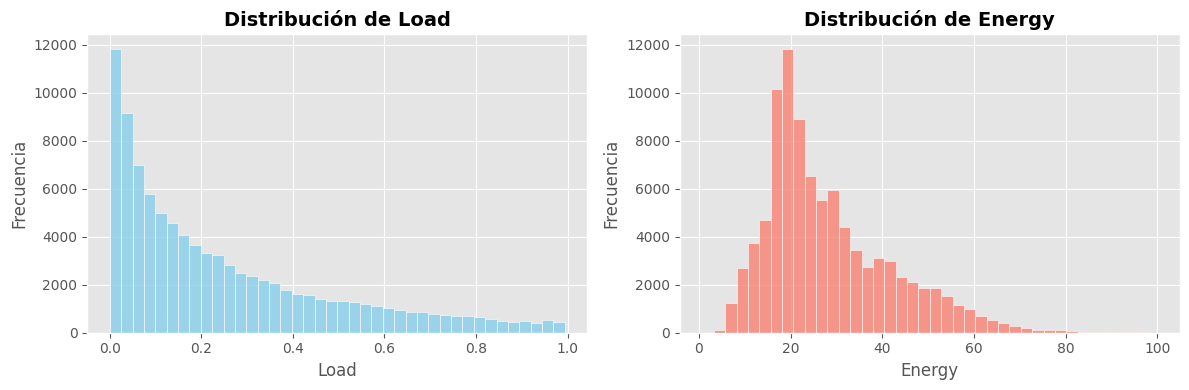

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histograma de Load
axes[0].hist(df_merge_total['load'], bins=40, color='skyblue', edgecolor='white', alpha=0.8)
axes[0].set_title("Distribución de Load", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Load", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)

# Histograma de Energy
axes[1].hist(df_merge_total['Energy'], bins=40, color='salmon', edgecolor='white', alpha=0.8)
axes[1].set_title("Distribución de Energy", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Energy", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)

plt.tight_layout()
plt.show()

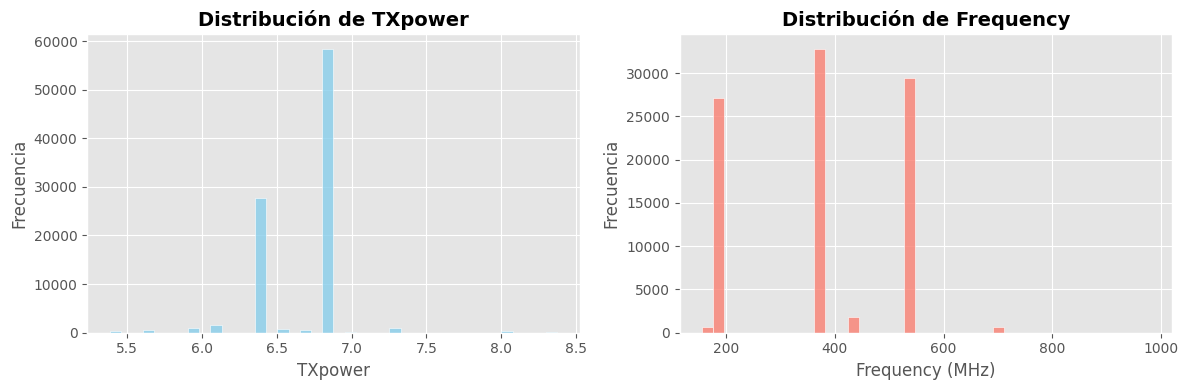

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histograma de TXpower
axes[0].hist(df_merge_total['TXpower'], bins=40, color='skyblue', edgecolor='white', alpha=0.8)
axes[0].set_title("Distribución de TXpower", fontsize=14, fontweight='bold')
axes[0].set_xlabel("TXpower", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)

# Histograma de Frequency
axes[1].hist(df_merge_total['Frequency'], bins=40, color='salmon', edgecolor='white', alpha=0.8)
axes[1].set_title("Distribución de Frequency", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Frequency (MHz)", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)

plt.tight_layout()
plt.show()

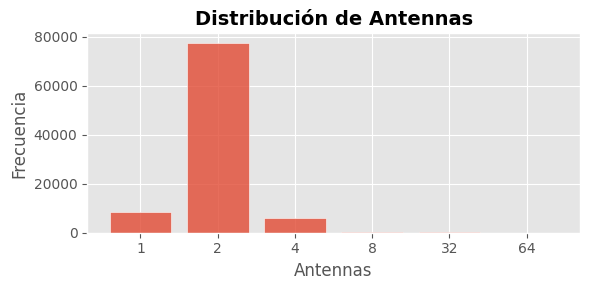

In [10]:
# Calcula conteo de cada valor de Antennas
counts = df_merge_total['Antennas'].value_counts().sort_index()

plt.figure(figsize=(6, 3))
plt.bar(counts.index.astype(str), counts.values, edgecolor='white', alpha=0.8)
plt.title("Distribución de Antennas", fontsize=14, fontweight='bold')
plt.xlabel("Antennas", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)

# Ajusta los ticks del eje X para que solo aparezcan los valores presentes
plt.xticks(counts.index.astype(str))

plt.tight_layout()
plt.show()

### Correlación

Energy             1.000000
load               0.668345
Antennas_1         0.373785
Bandwidth          0.341766
Frequency_1        0.293839
same_time_cells    0.267505
ESMode3_1          0.266937
TXpower_1          0.266366
ESMode2_1          0.264769
ESMode1_1          0.264159
ESMode6_1          0.263154
TXpower            0.253033
load_1             0.242942
Antennas           0.170925
ESMode3            0.016501
Frequency          0.012707
ESMode6           -0.061041
Bandwidth_1       -0.223686
ESMode2           -0.270284
ESMode1           -0.272003
Name: Energy, dtype: float64


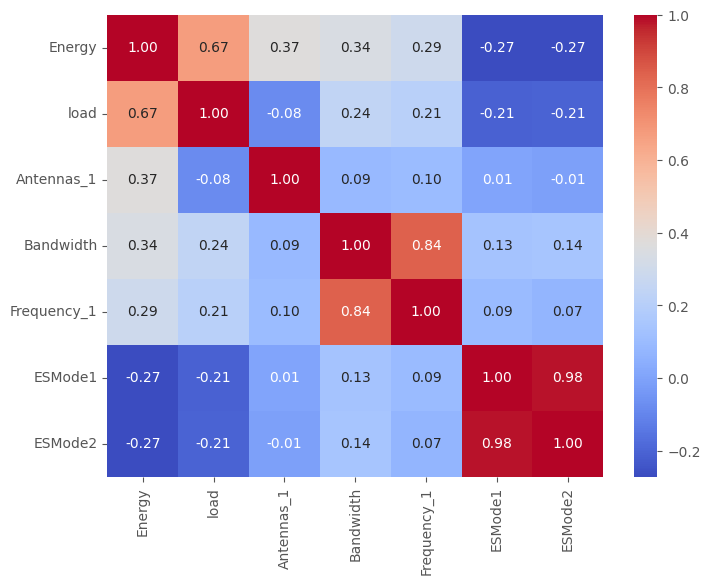

In [11]:
corr = df_merge_total.corr(numeric_only= True)
print(corr['Energy'].sort_values(ascending=False))  # ordenado por relación con Energy

plt.figure(figsize=(8,6))
sns.heatmap(corr.loc[
      ['Energy'] + corr['Energy'].abs().drop('Energy').nlargest(6).index.tolist(),
      ['Energy'] + corr['Energy'].abs().drop('Energy').nlargest(6).index.tolist()
    ], annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Relación Load y Energy

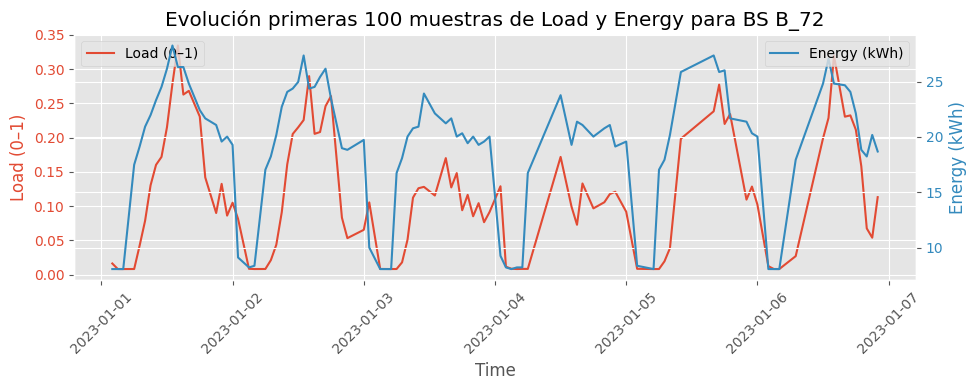

In [12]:
import random

bs_random = random.choice(df_merge_total["BS"].unique().tolist())
df_bs = df_merge_total[df_merge_total["BS"] == bs_random].copy()

# 5) Coge sólo las primeras 100 muestras cronológicas
df_plot = df_bs.iloc[:100]

# 6) Dibuja ambas series sobre el mismo Time
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(df_plot["Time"], df_plot["load"],  color="C0", label="Load (0–1)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Load (0–1)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_plot["Time"], df_plot["Energy"], color="C1", label="Energy (kWh)")
ax2.set_ylabel("Energy (kWh)", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

# Leyendas
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title(f"Evolución primeras 100 muestras de Load y Energy para BS {bs_random}")
plt.tight_layout()
plt.show()

## Feature Engineering

### Generación de variables temporales y cíclicas

En este fragmento de código se crean nuevas **features** basadas en la columna temporal `Time` para ambos DataFrames (`df_merge_total` y `df_prediction_total`):

1. **Componentes de fecha y hora**  
   - `hour`: hora del día (0–23)  
   - `weekday`: día de la semana (0=Lunes … 6=Domingo)  
   - `month`: mes del año (1–12)  
   - `day of year`: día del año (1–365/366)  
2. **Indicador de fin de semana**  
   - `is_weekend`: 1 si el día es sábado o domingo, 0 en caso contrario.  
3. **Codificación cíclica de la hora**  
   Para que los modelos de Machine Learning capturen la naturaleza circular de las horas:
   - `sin_hour` = sin(2·π·hour/24)  
   - `cos_hour` = cos(2·π·hour/24)  

In [13]:
df_merge_total['hour']   = df_merge_total['Time'].dt.hour
df_merge_total['weekday']= df_merge_total['Time'].dt.weekday
df_merge_total['month']  = df_merge_total['Time'].dt.month
df_merge_total['day of year']  = df_merge_total['Time'].dt.dayofyear
df_merge_total['is_weekend']  = (df_merge_total['weekday'] >= 5).astype(int)
df_merge_total['sin_hour'] = np.sin(2*np.pi*df_merge_total['hour']/24)
df_merge_total['cos_hour'] = np.cos(2*np.pi*df_merge_total['hour']/24)


df_prediction_total['hour']   = df_prediction_total['Time'].dt.hour
df_prediction_total['weekday']= df_prediction_total['Time'].dt.weekday
df_prediction_total['month']  = df_prediction_total['Time'].dt.month
df_prediction_total['day of year']  = df_prediction_total['Time'].dt.dayofyear
df_prediction_total['is_weekend']  = (df_prediction_total['weekday'] >= 5).astype(int)
df_prediction_total['sin_hour'] = np.sin(2*np.pi*df_prediction_total['hour']/24)
df_prediction_total['cos_hour'] = np.cos(2*np.pi*df_prediction_total['hour']/24)

### Generación de métricas derivadas de la carga entre celdas

En este fragmento se crean nuevas **features** que describen la relación entre las cargas de las dos celdas (`load` y `load_1`) para ambos DataFrames (`df_merge_total` y `df_prediction_total`):

- `load_sum`: suma de las dos cargas.  
- `mult_sum`: producto de las dos cargas.  
- `mean_sum`: media aritmética de las dos cargas.  
- `abs_diff`: diferencia absoluta entre las dos cargas.  
- `max_load`: carga máxima.  
- `min_load`: carga mínima.  
- `std_load`: desviación estándar de las dos cargas.  
- `var_load`: varianza de las dos cargas.  
- `ratio_load`: cociente entre `load` y `load_1` (se añade un pequeño `eps` para evitar división por cero).


In [14]:
df_merge_total["load_sum"] = df_merge_total[["load", "load_1"]].sum(1)
df_merge_total["mult_sum"] = df_merge_total["load"] * df_merge_total["load_1"]
df_merge_total["mean_sum"] = df_merge_total[["load", "load_1"]].mean(axis=1)
df_merge_total["abs_diff"] = (df_merge_total["load"] - df_merge_total["load_1"]).abs()
df_merge_total["max_load"] = df_merge_total[["load","load_1"]].max(axis=1)
df_merge_total["min_load"] = df_merge_total[["load","load_1"]].min(axis=1)

df_merge_total['std_load'] = df_merge_total[['load','load_1']].std(axis=1)
df_merge_total['var_load'] = df_merge_total[['load','load_1']].var(axis=1)

eps = 1e-6  # para evitar división por cero
df_merge_total['ratio_load'] = df_merge_total['load'] / (df_merge_total['load_1'] + eps)


df_prediction_total["load_sum"] = df_prediction_total[["load", "load_1"]].sum(1)
df_prediction_total["mult_sum"] = df_prediction_total["load"] * df_prediction_total["load_1"]
df_prediction_total["mean_sum"] = df_prediction_total[["load", "load_1"]].mean(axis=1)
df_prediction_total["abs_diff"] = (df_prediction_total["load"] - df_prediction_total["load_1"]).abs()
df_prediction_total["max_load"] = df_prediction_total[["load","load_1"]].max(axis=1)
df_prediction_total["min_load"] = df_prediction_total[["load","load_1"]].min(axis=1)

df_prediction_total['std_load'] = df_prediction_total[['load','load_1']].std(axis=1)
df_prediction_total['var_load'] = df_prediction_total[['load','load_1']].var(axis=1)

eps = 1e-6  # para evitar división por cero
df_prediction_total['ratio_load'] = df_prediction_total['load'] / (df_prediction_total['load_1'] + eps)

### Codificación ordinal de variables categóricas

En este fragmento de código se aplica un **OrdinalEncoder** para transformar variables categóricas en valores numéricos:

1. Se importa e instancia `OrdinalEncoder` con  
   - `handle_unknown="use_encoded_value"`: asigna un valor fijo a categorías desconocidas.  
   - `unknown_value=-1`: valor que se usará para categorías no vistas durante el ajuste.  
2. Se ajusta (`fit_transform`) el codificador a las columnas `BS`, `Mode`, `RUType`, `Mode_1` y `RUType_1` de `df_merge_total`, reemplazándolas por sus códigos ordinales.  
3. Se vuelve a aplicar (`fit_transform`) el mismo encodificador a las mismas columnas de `df_prediction_total`, garantizando consistencia en la codificación.


In [15]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_merge_total[['BS', 'Mode', 'RUType', 'Mode_1', 'RUType_1']] = ordinal_encoder.fit_transform(df_merge_total[['BS', 'Mode', 'RUType', 'Mode_1', 'RUType_1']])
df_prediction_total[['BS', 'Mode', 'RUType', 'Mode_1', 'RUType_1']] = ordinal_encoder.fit_transform(df_prediction_total[['BS', 'Mode', 'RUType', 'Mode_1', 'RUType_1']])

### Cálculo del ratio de utilización de potencia

En este fragmento se crea una nueva **feature** que mide la eficiencia de la carga respecto a la potencia de transmisión:

- `Power_Utilization_Ratio`: cociente entre la carga (`load`) y la potencia de transmisión (`TXpower`), con un pequeño término `1e-3` para evitar división por cero.  
- `Power_Utilization_Ratio_1`: mismo cociente, pero usando la carga y la potencia de la celda secundaria (`load_1` y `TXpower_1`).  

Se calcula de forma análoga tanto en `df_merge_total` como en `df_prediction_total`.


In [16]:
df_merge_total['Power_Utilization_Ratio'] = df_merge_total['load'] / (df_merge_total['TXpower'] + 1e-3)
df_merge_total['Power_Utilization_Ratio_1'] = df_merge_total['load_1'] / (df_merge_total['TXpower_1'] + 1e-3)

df_prediction_total['Power_Utilization_Ratio'] = df_prediction_total['load'] / (df_prediction_total['TXpower'] + 1e-3)
df_prediction_total['Power_Utilization_Ratio_1'] = df_prediction_total['load_1'] / (df_prediction_total['TXpower_1'] + 1e-3)

In [17]:
df_merge_total.head()

,Time,BS,Energy,load,ESMode1,ESMode2,ESMode3,ESMode6,same_time_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,RUType_1,Mode_1,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1,hour,weekday,month,day of year,is_weekend,sin_hour,cos_hour,load_sum,mult_sum,mean_sum,abs_diff,max_load,min_load,std_load,var_load,ratio_load,Power_Utilization_Ratio,Power_Utilization_Ratio_1
0,2023-01-01 01:00:00,0.0,64.275037,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,0.0,1.0,426.98,2.0,4.0,7.327504,1,6,1,1,1,0.258819,0.965926,0.487936,0.0,0.243968,0.487936,0.487936,0.0,0.345023,0.119041,487936.170,0.070953,0.0
1,2023-01-01 02:00:00,0.0,55.904335,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,0.0,1.0,426.98,2.0,4.0,7.327504,2,6,1,1,1,0.500000,0.866025,0.344468,0.0,0.172234,0.344468,0.344468,0.0,0.243576,0.059329,344468.085,0.050090,0.0
2,2023-01-01 03:00:00,0.0,57.698057,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,0.0,1.0,426.98,2.0,4.0,7.327504,3,6,1,1,1,0.707107,0.707107,0.193766,0.0,0.096883,0.193766,0.193766,0.0,0.137013,0.018773,193765.957,0.028176,0.0
3,2023-01-01 04:00:00,0.0,55.156951,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,0.0,1.0,426.98,2.0,4.0,7.327504,4,6,1,1,1,0.866025,0.500000,0.222383,0.0,0.111191,0.222383,0.222383,0.0,0.157249,0.024727,222382.979,0.032338,0.0
4,2023-01-01 05:00:00,0.0,56.053812,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,365.0,20,4,6.875934,0.0,1.0,426.98,2.0,4.0,7.327504,5,6,1,1,1,0.965926,0.258819,0.175436,0.0,0.087718,0.175436,0.175436,0.0,0.124052,0.015389,175436.170,0.025511,0.0


## Modelo

La estimación de energía se realizará mediante un modelo XGBRegressor.

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
import optuna

Definimos la función de pérdida:

$$
\mathrm{WMAPE} \;=\;
\frac{\displaystyle\sum_{i=1}^{N} w_i \,\bigl|y_i - \hat y_i\bigr|}
     {\displaystyle\sum_{i=1}^{N} w_i \,y_i}
$$

In [19]:
# Función de perdida WMAPE
def wmape(y_true, y_pred, w):
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w * np.abs(y_true))

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def study_model(X, y, w_val = None):

    def objective(trial):
        params = {
            'tree_method':     'gpu_hist',
            'predictor':       'gpu_predictor',
            'objective':       'reg:gamma',
            'n_estimators':    trial.suggest_int('n_estimators', 500, 3000, step=100),
            'learning_rate':   trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth':       trial.suggest_int('max_depth', 3, 12),
            'subsample':       trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree':trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'reg_alpha':       trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda':      trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state':    42,
            'verbosity':       0,
            'n_jobs':         -1
        }
        wmape_scores = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            if w_val is None:
                w_val_ = np.ones(len(y_val))
            else:
                w_val_ = w_val.iloc[val_idx]
            model = XGBRegressor(**params)
            model.fit(X_tr, y_tr)

            preds = model.predict(X_val)
            wmape_scores.append(wmape(y_val.values, preds, w_val_))

        return np.mean(wmape_scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, timeout=1000)

    print("Mejor MAPE CV encontrado:", study.best_value)
    print("Mejores parámetros:")
    for k, v in study.best_params.items():
        print(f"   • {k}: {v}")
    best_params = study.best_params

    return best_params

### Objetivo A: Desarrollar un modelo capaz de estimar la energía consumida por diferentes productos de estación base.
Los participantes deberán desarrollar un modelo que estime la energía consumida por diferentes productos de estación base, teniendo en cuenta el impacto de diversas configuraciones de ingeniería, condiciones de tráfico y métodos de ahorro de energía.

In [21]:
df_trainval = df_merge_total.copy()
mask_valid = df_trainval['Energy'].notnull() & np.isfinite(df_trainval['Energy'])
df_trainval = df_trainval.loc[mask_valid].reset_index(drop=True)

# Objetivo A: 
feature_cols = [c for c in df_trainval.columns if c not in ('Energy', 'Time')]

X_A = df_trainval[feature_cols]
y_A = df_trainval['Energy']

In [22]:
best_params = study_model(X_A, y_A)
best_params.update({
    'objective': 'reg:gamma',
    'eval_metric': 'mape',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1
})

final_model_A = XGBRegressor(**best_params)
final_model_A.fit(X_A, y_A)

[I 2025-06-29 19:25:54,622] A new study created in memory with name: no-name-2db21e29-3976-4d7d-9719-ec605ce1922f
[I 2025-06-29 19:26:46,455] Trial 0 finished with value: 0.05170943434319606 and parameters: {'n_estimators': 1700, 'learning_rate': 0.022050580592214868, 'max_depth': 8, 'subsample': 0.7281465051866575, 'colsample_bytree': 0.44259767921964843, 'reg_alpha': 1.0323108043599118e-06, 'reg_lambda': 7.041366700179942}. Best is trial 0 with value: 0.05170943434319606.
[I 2025-06-29 19:27:05,320] Trial 1 finished with value: 0.055281186449079624 and parameters: {'n_estimators': 1400, 'learning_rate': 0.06838255568136228, 'max_depth': 5, 'subsample': 0.6084857857093855, 'colsample_bytree': 0.4575338864230681, 'reg_alpha': 3.670546706857119e-05, 'reg_lambda': 0.014559333213997492}. Best is trial 0 with value: 0.05170943434319606.
[I 2025-06-29 19:27:29,566] Trial 2 finished with value: 0.060175772974352684 and parameters: {'n_estimators': 2300, 'learning_rate': 0.03738104867750424, 

Mejor MAPE CV encontrado: 0.047339507709742636
Mejores parámetros:
   • n_estimators: 3000
   • learning_rate: 0.01008095997229715
   • max_depth: 10
   • subsample: 0.659396919033193
   • colsample_bytree: 0.9920050021577534
   • reg_alpha: 1.2483411962200702e-05
   • reg_lambda: 7.648357759255971e-08


,objective,'reg:gamma'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9920050021577534
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mape'


### Objetivo B: Lograr la capacidad de generalización entre distintos productos de estación base.
El modelo debe estimar el consumo de energía de un nuevo producto de estación base a partir de las mediciones recogidas de otros ya existentes, como los productos A, B y C. Por ejemplo, si se dispone de datos de entrenamiento para estos tres productos, el modelo debe ser capaz de proporcionar una estimación de la energía consumida por el producto D.

In [38]:
df_trainval = df_merge_total.copy()
mask_valid = df_trainval['Energy'].notnull() & np.isfinite(df_trainval['Energy'])
df_trainval = df_trainval.loc[mask_valid].reset_index(drop=True)

# Objetivo B: 
bs_all = df_trainval['BS'].unique()
n_bs_val = int(0.2 * len(bs_all))
bs_val = np.random.choice(bs_all, size=n_bs_val, replace=False)

df_trainval['is_val'] = df_trainval['BS'].isin(bs_val)
df_trainval['w'] = 1
df_trainval.loc[df_trainval['is_val'], 'w'] = 5

train_df = df_trainval.loc[~df_trainval['is_val']]
val_df = df_trainval.loc[df_trainval['is_val']]

X_train, y_train = train_df[feature_cols], train_df['Energy']
X_val, y_val = val_df[feature_cols], val_df['Energy']
w_train = train_df['w']
w_val = val_df['w']

In [39]:
best_params = study_model(X_train, y_train, w_train)
best_params.update({
    'objective':    'reg:gamma',
    'random_state': 42,
    'verbosity':    0,
    'n_jobs':      -1
})

final_model_B = XGBRegressor(**best_params)
final_model_B.fit(X_train, y_train)

y_val_pred = final_model_B.predict(X_val)
print("WMAPE sobre BS nuevas:", wmape(y_val.values, y_val_pred, w_val.values))


[I 2025-06-29 20:18:56,153] A new study created in memory with name: no-name-5a770690-5a43-4236-8ba0-0777201340c2
[I 2025-06-29 20:19:39,437] Trial 0 finished with value: 0.04731864578140692 and parameters: {'n_estimators': 1800, 'learning_rate': 0.13490684791051855, 'max_depth': 7, 'subsample': 0.9732536992875227, 'colsample_bytree': 0.917229483621893, 'reg_alpha': 1.3433431932941642, 'reg_lambda': 2.6848958728376027e-05}. Best is trial 0 with value: 0.04731864578140692.
[I 2025-06-29 20:19:59,993] Trial 1 finished with value: 0.0703532835206232 and parameters: {'n_estimators': 1500, 'learning_rate': 0.013737237985485146, 'max_depth': 5, 'subsample': 0.7339786429956532, 'colsample_bytree': 0.33761025431307345, 'reg_alpha': 0.007682673903795581, 'reg_lambda': 3.594261605565145e-08}. Best is trial 0 with value: 0.04731864578140692.
[I 2025-06-29 20:20:30,879] Trial 2 finished with value: 0.05196389776379895 and parameters: {'n_estimators': 1700, 'learning_rate': 0.2933262591462382, 'max

Mejor MAPE CV encontrado: 0.04603874270174911
Mejores parámetros:
   • n_estimators: 1600
   • learning_rate: 0.028948222169899115
   • max_depth: 10
   • subsample: 0.8005512132492449
   • colsample_bytree: 0.8878399600851876
   • reg_alpha: 2.705848504063332e-07
   • reg_lambda: 8.984726251616368e-06
WMAPE sobre BS nuevas: 0.10100114614442525


### Objetivo C: Alcanzar capacidades de generalización a través de diferentes configuraciones de estaciones base.
El modelo debe predecir el consumo de energía de los parámetros recién configurados basándose en un pequeño número de parámetros reales de configuración de la red. Por ejemplo, si los datos de entrenamiento contienen muestras recogidas de muchos productos de estaciones base, cuando la potencia de transmisión se establece en 30, 35 y 43 dBm, el modelo debe estimar la energía consumida cuando la potencia de transmisión se establece en 40 dBm.

In [40]:
df = df_merge_total.copy()
mask_valid = df['Energy'].notnull() & np.isfinite(df['Energy'])
df = df.loc[mask_valid].reset_index(drop=True)

np.random.seed(42)
bs_all      = df['BS'].unique()
rutype_all  = df['RUType'].unique()

n_bs_val     = int(0.2 * len(bs_all))
n_rut_val    = max(1, int(0.2 * len(rutype_all)))  

bs_val       = np.random.choice(bs_all,    size=n_bs_val,    replace=False)
rutype_val   = np.random.choice(rutype_all,size=n_rut_val,    replace=False)

df['is_val'] = df['BS'].isin(bs_val) | df['RUType'].isin(rutype_val)
df['w']      = 1
df.loc[df['BS'].isin(bs_val), 'w'] = 5

feature_cols = [c for c in df.columns if c not in ('Energy','Time','is_val','w')]
train_df = df.loc[~df['is_val']]
val_df   = df.loc[ df['is_val']]


X_train = train_df[feature_cols]
y_train = train_df['Energy']
X_val   = val_df[feature_cols]
y_val   = val_df['Energy']
w_train   = train_df['w']
w_val   = val_df['w']

In [41]:
best_params = study_model(X_train, y_train, w_train)
best_params.update({
    'objective':    'reg:gamma',
    'random_state': 42,
    'verbosity':    0,
    'n_jobs':      -1
})

final_model_C = XGBRegressor(**best_params)
final_model_C.fit(X_train, y_train)

y_val_pred = final_model_C.predict(X_val)
print("WMAPE sobre BS y RUType nuevos:", wmape(y_val.values, y_val_pred, w_val.values))


[I 2025-06-29 20:39:37,608] A new study created in memory with name: no-name-4934b7a3-262d-4c65-a117-813c5908ef97
[I 2025-06-29 20:39:42,846] Trial 0 finished with value: 0.05427196699527671 and parameters: {'n_estimators': 500, 'learning_rate': 0.09133595232512377, 'max_depth': 4, 'subsample': 0.5861803948892562, 'colsample_bytree': 0.7041910746390839, 'reg_alpha': 1.4234194360687711e-08, 'reg_lambda': 0.06826545220686508}. Best is trial 0 with value: 0.05427196699527671.
[I 2025-06-29 20:40:44,159] Trial 1 finished with value: 0.043002198097280515 and parameters: {'n_estimators': 3000, 'learning_rate': 0.011715681439773187, 'max_depth': 7, 'subsample': 0.7250994681086033, 'colsample_bytree': 0.5279367235533592, 'reg_alpha': 4.977990305497298e-06, 'reg_lambda': 1.4582634072707308e-06}. Best is trial 1 with value: 0.043002198097280515.
[I 2025-06-29 20:41:31,010] Trial 2 finished with value: 0.044292912043664444 and parameters: {'n_estimators': 2900, 'learning_rate': 0.0199400502560637

Mejor MAPE CV encontrado: 0.0410144016058198
Mejores parámetros:
   • n_estimators: 1200
   • learning_rate: 0.03905726718971948
   • max_depth: 8
   • subsample: 0.8275067875667272
   • colsample_bytree: 0.843949885498826
   • reg_alpha: 7.167937467031681e-07
   • reg_lambda: 7.700811094857237e-07
WMAPE sobre BS y RUType nuevos: 0.12976285936665635
